In [222]:

import nltk
import numpy as np
import pandas as pd
import re
import string
import os
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [221]:
import pandas as pd
data = pd.read_csv('US Airline.csv')
#data = pd.read_csv('Tweets.csv')

In [6]:
data.head(100)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,569910981868060673,negative,1.0000,Customer Service Issue,0.6863,Virgin America,NaN,MerchEngines,NaN,0,"@VirginAmerica Is it me, or is your website do...",NaN,2015-02-23 09:25:41 -0800,"Los Angeles, CA",Arizona
96,569909224521641984,negative,1.0000,Customer Service Issue,0.6771,Virgin America,NaN,ColorCartel,NaN,0,@VirginAmerica I can't check in or add a bag. ...,NaN,2015-02-23 09:18:42 -0800,"Austin, TX",Mountain Time (US & Canada)
97,569907336485019648,negative,1.0000,Can't Tell,0.6590,Virgin America,NaN,MustBeSpoken,NaN,0,@VirginAmerica - Let 2 scanned in passengers l...,NaN,2015-02-23 09:11:12 -0800,NaN,NaN
98,569896805611089920,negative,1.0000,Flight Booking Problems,0.6714,Virgin America,NaN,mattbunk,NaN,0,@virginamerica What is your phone number. I ca...,NaN,2015-02-23 08:29:21 -0800,"Sterling Heights, MI",Eastern Time (US & Canada)


In [43]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

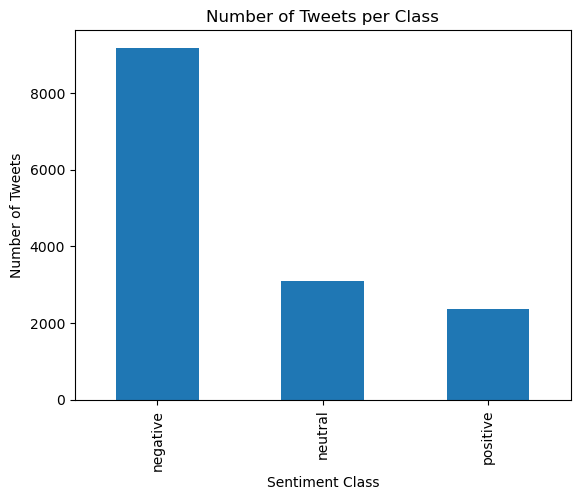

In [44]:
import matplotlib.pyplot as plt
counts = data['airline_sentiment'].value_counts()
counts.plot(kind='bar')

plt.title('Number of Tweets per Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.show()

<Figure size 1000x2000 with 0 Axes>

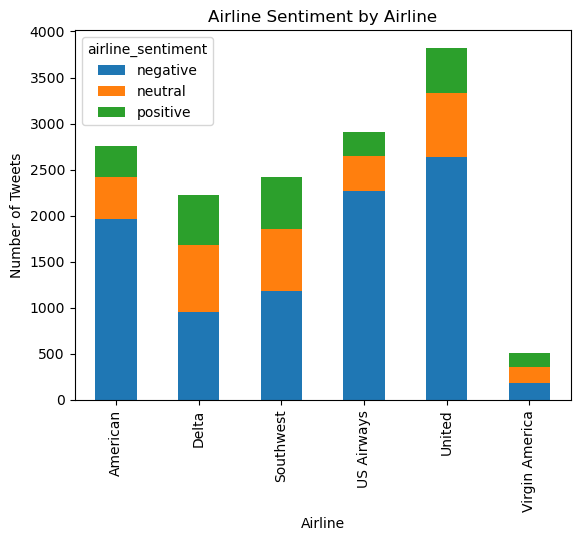

In [45]:
import matplotlib.pyplot as plt
grouped = data.groupby(['airline', 'airline_sentiment']).size().unstack()

fig = plt.figure(figsize = (10,20))
grouped.plot(kind='bar', stacked=True)
plt.title('Airline Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.show()

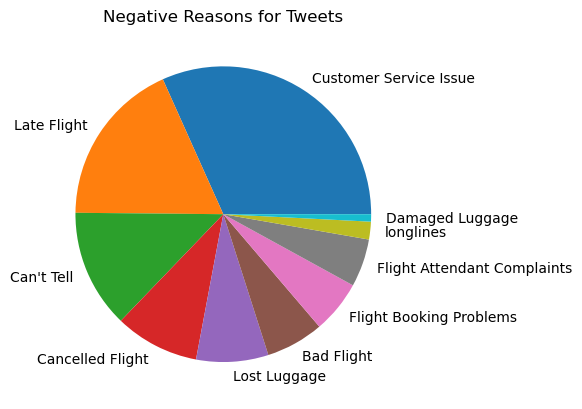

In [46]:
neg_reason_counts = data['negativereason'].value_counts()

plt.pie(neg_reason_counts, labels=neg_reason_counts.index)
plt.title('Negative Reasons for Tweets')
plt.show()

In [47]:
# Separate negative and positive sentiment tweets
neg_data = data[data['airline_sentiment'] == 'negative']
pos_data = data[data['airline_sentiment'] == 'positive']

# Sample an equal number of negative and positive tweets
num_samples = min(len(neg_data), len(pos_data))
neg_data = neg_data.sample(n=num_samples, random_state=42)
pos_data = pos_data.sample(n=num_samples, random_state=42)

# Concatenate the negative and positive sentiment tweets
balanced_data = pd.concat([neg_data, pos_data])

# Shuffle the rows
balanced_data = balanced_data.sample(frac=1, random_state=42)

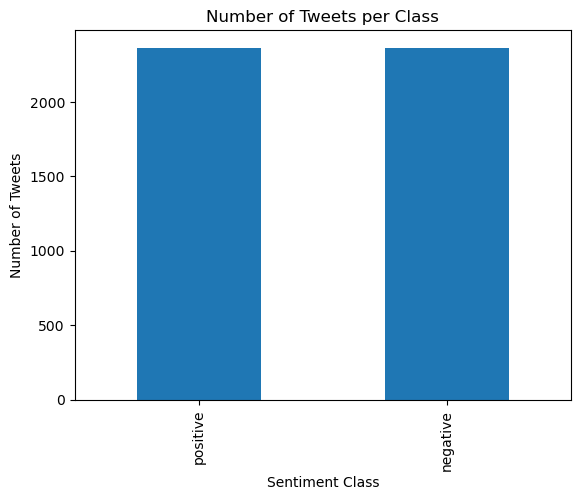

In [18]:
counts = balanced_data['airline_sentiment'].value_counts()
counts.plot(kind='bar')

plt.title('Number of Tweets per Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.show()

In [19]:
print('Number of positive sentiment tweets: {}'.format(len(pos_data)))
print('Number of negative sentiment tweets: {}'.format(len(neg_data)))

Number of positive sentiment tweets: 2363
Number of negative sentiment tweets: 2363


In [21]:
from sklearn.model_selection import train_test_split

# Split into features and target
X = balanced_data['text'].values.tolist()
y = balanced_data['airline_sentiment'].values.tolist()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = 42)

In [23]:
# Map positive to 1 and negative to 0
y_train = [int(sent == 'positive') for sent in y_train]
y_test = [int(sent == 'positive') for sent in y_test]

In [66]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet (str): a string containing a tweet
    Output:
        tweets_clean (list): a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [69]:
sample_tweet = X_train[0]
print('Tweet before preprocessing: {}'.format(sample_tweet))
#print('Tweet after preprocessing: {}'.format(process_tweet(sample_tweet)))

Tweet before preprocessing: @JetBlue Another awesome telephone experience with @JetBlue Thank you, Cory! #Greatcustomerservice✈☺


In [ ]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets (list): a list of tweets
        ys (np.array): an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
        freqs (Dictionary): a dictionary mapping each (word, sentiment) pair to its frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [ ]:
freqs = build_freqs(X_train, y_train)

In [29]:
T = len(X_train)
T_pos = y_train.count(1)
T_neg = y_train.count(0)

print('Total number of tweets: {}'.format(T))
print('Number of positive tweets: {}'.format(T_pos))
print('Number of negative tweets: {}'.format(T_neg))

Total number of tweets: 3780
Number of positive tweets: 0
Number of negative tweets: 3780


In [49]:
# Calculate the probabilities for each class
Prob_T_pos = T_pos/T
Prob_T_neg = T_neg/T

print('Probability of positive class: {}'.format(Prob_T_pos))
print('Probability of negative class: {}'.format(Prob_T_neg))

Probability of positive class: 0.0
Probability of negative class: 1.0


In [58]:
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
# Removing stop words using nltk lib

#Tokenization of text
tokenizer=ToktokTokenizer() 

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#Removing standard english stopwords like prepositions, adverbs
stop = set(stopwords.words('english'))
print("NLTK stop word lists \n")
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

NLTK stop word lists 

{'it', "you'll", 'can', "you're", 'same', 'very', 'most', 'you', 'mightn', 'needn', 'then', 'own', 'ours', 'any', 'from', 'his', 'more', 'wasn', 'wouldn', 'or', 'below', 'about', 'when', "didn't", 'this', 'hers', 'are', 'over', 'some', "it's", 'a', 'under', 'doesn', 'ourselves', 'why', 'will', 'while', 'hadn', 'no', 'again', "won't", 'during', "mightn't", 'through', 'mustn', "doesn't", 'ma', 'her', 'myself', 'doing', 'further', 'ain', 'your', 'been', 'did', 'shouldn', 'me', "you'd", "wasn't", 'the', 'between', 'nor', 'm', 'hasn', 'on', 'into', 'which', 'as', 'should', 'before', 'were', 'our', "isn't", 'if', 'him', 'in', 'do', 'once', 'than', 'shan', 'i', 'where', 'how', 'itself', 's', 'being', "don't", 'not', 'is', 'such', 'so', 'having', "couldn't", 'am', 'these', 'don', 're', 'who', 'has', 'they', 'because', 'their', 'of', 'but', 'isn', 'few', 'didn', 'down', 'my', 'she', 'be', 'herself', 'by', 'yourself', 'had', 've', 'and', "she's", 'whom', "mustn't", 'that',

In [73]:
df_clean = pd.DataFrame({'clean'})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
df_clean.head(5)

(1, 1)


,0
0,clean


In [ ]:
train = pd.read_csv('US Airline.csv')

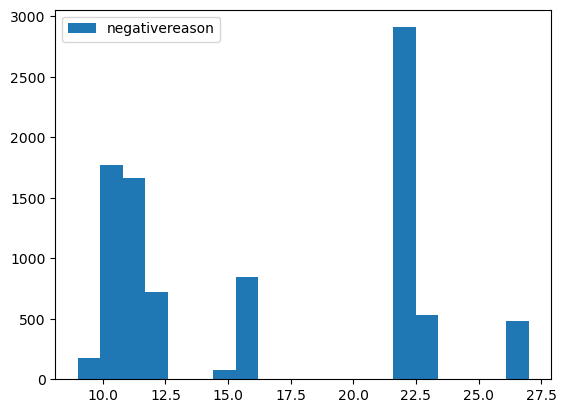

In [115]:

length_train_dataset = train['negativereason'].str.len()
#length_test_dataset = test['tweet'].str.len()
plt.hist(length_train_dataset, bins=20,label="negativereason")
#plt.hist(length_test_dataset, bins=20,label="negativereason")
plt.legend() 
plt.show()

In [122]:
combine=train.append(train,ignore_index=True) #train and test dataset are combined
combine.shape

C:\Users\steph\AppData\Local\Temp\ipykernel_12464\331631887.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combine=train.append(train,ignore_index=True) #train and test dataset are combined


(29280, 15)

In [128]:
combine.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [138]:
combine['tidy_text'] = np.vectorize(remove_pattern)(combine['text'],"@[\w]*") 
combine.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tidy_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""en..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


In [139]:
combine['tidy_text'] = combine['tidy_text'].str.replace("[^a-zA-Z#]"," ")
combine.head(10)

C:\Users\steph\AppData\Local\Temp\ipykernel_12464\855367996.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  combine['tidy_text'] = combine['tidy_text'].str.replace("[^a-zA-Z#]"," ")


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tidy_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you ve added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn t today Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it s really aggressive to blast obnoxious en...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it s a really big bad thing about it
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),seriously would pay a flight for seats th...
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),yes nearly every time I fly VX this ear wor...
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada),Really missed a prime opportunity for Men Wit...
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada),Well I didn t but NOW I DO D
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada),it was amazing and arrived an hour early Yo...


In [ ]:
combine['tidy_text'] = combine['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #removing words whose length is less than 3

In [140]:
combine.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tidy_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you ve added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn t today Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it s really aggressive to blast obnoxious en...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it s a really big bad thing about it


In [141]:
tokenized_tweet = combine['tidy_text'].apply(lambda x:x.split()) #it will split all words by whitespace
tokenized_tweet.head()

0                                         [What, said]
1    [plus, you, ve, added, commercials, to, the, e...
2    [I, didn, t, today, Must, mean, I, need, to, t...
3    [it, s, really, aggressive, to, blast, obnoxio...
4    [and, it, s, a, really, big, bad, thing, about...
Name: tidy_text, dtype: object

In [214]:
data[data['airline_sentiment']=="negative"]["text"]

3                                @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                                       @VirginAmerica and it's a really big bad thing about it
5                      @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
15                                                                                                                @VirginAmerica SFO-PDX schedule is still MIA.
17                    @VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!
                                                                                  ...                                                                          
14631                                   